# project 2 b) FNN code


In [2]:
import autograd.numpy as np  # We need to use this numpy wrapper to make automatic differentiation work later
from autograd import grad
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import scipy.special

from tqdm import tqdm
from joblib import Parallel, delayed

In [3]:

from p2_things import *


## FFNN CODE
for regression with a flexible number of hidden layers
and nodes using the Sigmoid function as activation function for the hidden layers.
Initialize the weights using a normal distribution.

How would you initialize the
biases? And which activation function would you select for the final output
layer?

The weight matrices are standard normally distributed.
The bias is chosen to be zero it only implies a shift of the values. In contrast to the weights, this is okay.
If however the weights were all initialized the neural network might end up training all nodes the same. Then, the nodes don't bring enough difference .


For the final activation layer choose simply the identity, as we don't have a classification setting where we want the values in a particular range.

In [7]:

from sklearn.metrics import mean_squared_error,  r2_score

## training

# here the things begin !!!

## Franke

In [59]:
def FrankeFunction(x,y, noise=0):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4 + noise*np.random.normal(0, 1, (n,n))

In [60]:
n = 20
x1 = np.linspace(0, 1, n)
x2 = np.linspace(0, 1, n)
x1m, x2m = np.meshgrid(x1,x2)
y = FrankeFunction(x1m, x2m, noise=0.0)

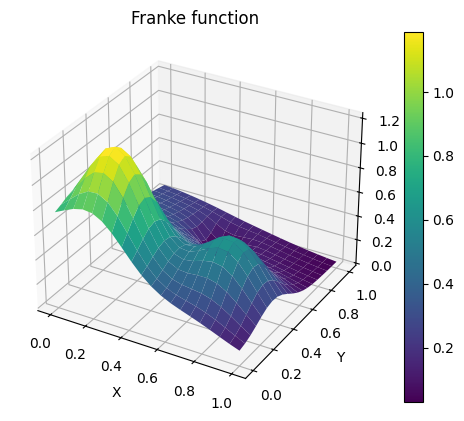

In [61]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x1m, x2m, y, cmap='viridis')
# ax.plot_surface(xm, ym, z, cmap='viridis')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
#add colorbarz_tilde_ridge.reshape(100,100)
plt.colorbar(surf)
plt.title('Franke function')
plt.show()

## neural network fitting:

In [62]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


x1 = x1m.flatten().reshape(-1,1)
x2 = x2m.flatten().reshape(-1,1)



x1_train, x1_test, x2_train, x2_test, y_train, y_test = train_test_split(x1,x2, y.flatten().reshape(-1,1), test_size=0.33, random_state=42)



# Scaling for NN
X_train = np.hstack((x1_train, x2_train))
X_test = np.hstack((x1_test, x2_test))

scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X_train)
X_test = scaler_X.fit_transform(X_test)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y)
y_scaled.shape

y_train = y_train.reshape((-1,1))
y_test = y_test.reshape((-1,1))
X_train = X_scaled


In [63]:
# chooose seed
np.random.seed(0)
# x from  0 to 1 


# HISHEM: 2, 50 , 25, 1


network_input_size = 2 # bcs have 2 features
layer_output_sizes = [50, 25, 1]
size_s = [network_input_size, layer_output_sizes]


activation_funcs = [sigmoid for i in range(len(layer_output_sizes)-1)]
activation_funcs.append(Id)
activation_ders = [sigmoid_der for i in range(len(layer_output_sizes)-1)]
activation_ders.append(lambda x: 1)

print(activation_funcs)

gamma=0.01
M = 16
n_epochs = 800

#layers_ffnn, mse_r2 = sgd_momentum(X_train,y_train, size_s, sum_c_i, 'FFNN', activation_funcs, activation_ders, cost_der=mse_der, lamb=0, n_epochs=n_epochs, M=M, gamma=gamma, momentum = 0.0, verbose=True, method2='regression',X_test=X_test, y_test=y_test)

[<function sigmoid at 0x7f80b46b27a0>, <function sigmoid at 0x7f80b46b27a0>, <function Id at 0x7f80b46b2e80>]


- Changing the batch size from 16 to 32 made the results worse, changing it to 8 comes with an improvement ! but it comes whith an increased computation time, where as using the size 32 reduces the computation
- If we decrease the batch size even to 4, the computation increases signigicantly, but so do the errors. we can observe than that e.g. aready 85 epochs would be sufficient compared to 100. as the MSE is less than 10 \% larger. considering the r2 score, we see that from the epochs number 60 on the r2 is greater than 0.995.

### try some different learning rates and epochs via crossvalidation:

In [63]:
from sklearn.model_selection import KFold
k = 5
kfold = KFold(n_splits = k)

gammas = [0.0001, 0.001, 0.01, 0.1, 1]
n_epochs = 500
batch_sizes = [4, 8, 16, 32, 64, 128]

Errors_CV = np.zeros((len(gammas), len(batch_sizes), 2))

def cross_validation_score(i, j, X, y):
    error_r2 = []
    error_mse = []
    for train_inds, test_inds in kfold.split(X):
        scalerX = MinMaxScaler()
        X_train = scalerX.fit_transform(X[train_inds])
        X_test = scalerX.fit_transform(X[test_inds])

        y_train = y[train_inds]
        y_test = y[test_inds]

        size_s = [2, [50, 25, 1]]

        M = batch_sizes[j]
        gamma = gammas[i]
        
        layers_final = sgd_momentum(X_train, y_train, size_s, sum_c_i, 'FFNN', activation_funcs, activation_ders, n_epochs=n_epochs, M=M, gamma=gamma, momentum=0, verbose=False, method2='regression')
        pred = feed_forward_batch(X_test, layers_final, activation_funcs)

        error_r2.append(r2_score(y_test, pred))
        error_mse.append(mean_squared_error(y_test, pred))

    #print(error_r2)
    mean_mse = np.mean(error_mse)
    mean_r2 = np.mean(error_r2)
    return i, j, mean_mse, mean_r2

In [ ]:
# Use joblib.Parallel to parallelize the inner loops
results = Parallel(n_jobs=-1)(delayed(cross_validation_score)(i, j, X_train, y_train) for i in tqdm(range(len(gammas)), desc='Outer Loop') for j in tqdm(range(len(batch_sizes)), desc='Inner Loop', leave=False))

# Collect the results
for i, j, mean_mse, mean_r2 in results:
    Errors_CV[i, j, 0] = mean_mse
    Errors_CV[i, j, 1] = mean_r2

#np.save('crossvalidation_of_layersizes10,25,50,75,100,125_gam0.01_M16_nepochs100_0-mse_1-r2_.npy', Errors_CV)

Inner Loop:   0%|                                         | 0/6 [00:00<?, ?it/s]
                                                                                
Inner Loop:   0%|                                         | 0/6 [00:00<?, ?it/s]

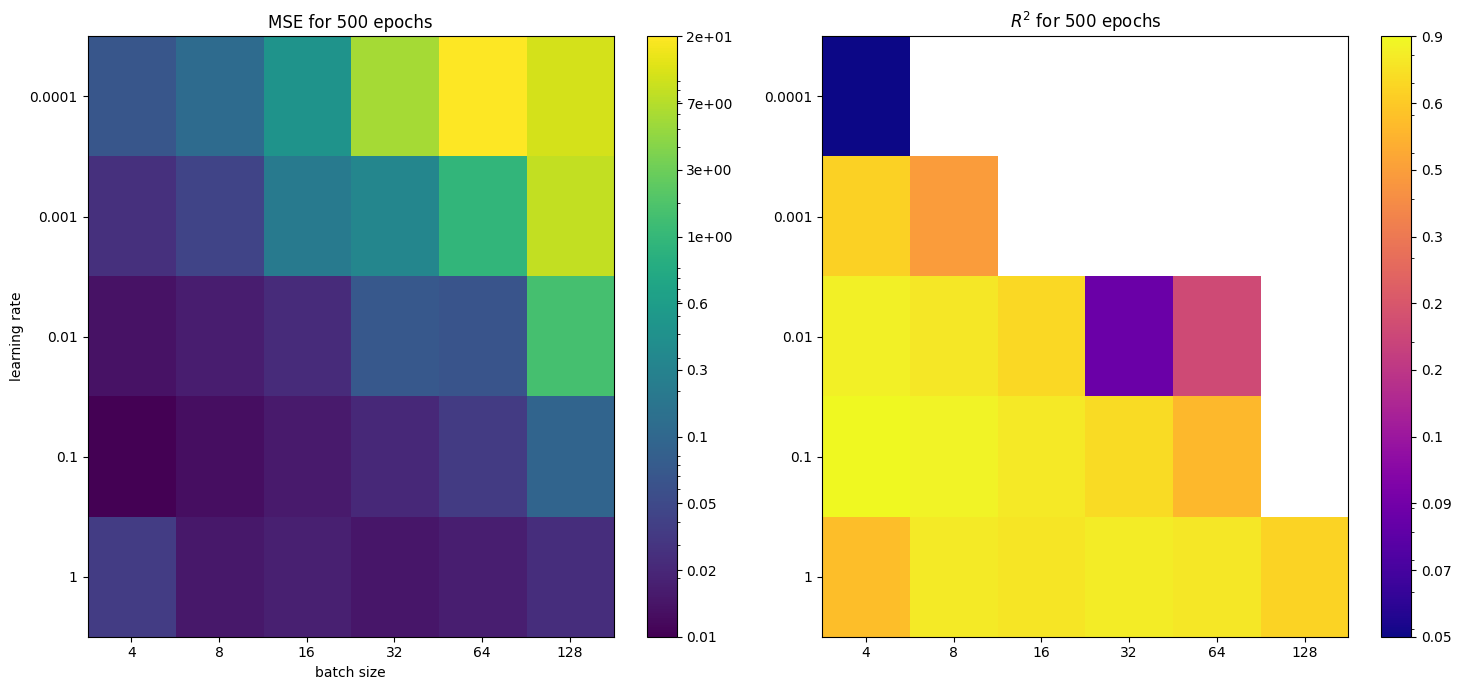

In [34]:
Errors_CV = np.load('crossvalidation_of_batchsizes4,8,16,32,64,128_and_gamma0.0001-1_nepochs500_momentum0_size_2,50,25,1_traindatatest_size=0.33,random_state=42_n-for-x1,x2=20.npy')

from matplotlib.colors import LogNorm
# Create a figure with two subplots
from copy import deepcopy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))  # 1 row, 2 columns

# Plot the first heatmap (MSE)
cax1 = ax1.imshow(Errors_CV[:, :, 0], cmap='viridis', aspect='auto', norm=LogNorm())
ax1.set_title('MSE for {} epochs'.format(n_epochs))

# Set x and y ticks and labels for the first heatmap
ax1.set_xticks(np.arange(len(batch_sizes)))
ax1.set_xticklabels(batch_sizes)
ax1.set_yticks(np.arange(len(gammas)))
ax1.set_yticklabels(gammas)
ax1.set_xlabel('batch size')
ax1.set_ylabel('learning rate')
cbar1 = fig.colorbar(cax1, ax=ax1)  # Add colorbar to the heatmap
ticks = np.logspace(np.log10(cax1.get_clim()[0]),np.log10(cax1.get_clim()[1]), 10)
cbar1.set_ticks(ticks)
cbar1.set_ticklabels([f'{t:.1}' for t in ticks])


# Plot the second heatmap (R^2)
cax2 = ax2.imshow(Errors_CV[:, :, 1], cmap='plasma', aspect='auto', norm=LogNorm())
ax2.set_title(r'$R^2$ for {} epochs'.format(n_epochs))

# Set x and y ticks and labels for the second heatmap
ax2.set_xticks(np.arange(len(batch_sizes)))
ax2.set_xticklabels(batch_sizes)
ax2.set_yticks(np.arange(len(gammas)))
ax2.set_yticklabels(gammas)
ax1.set_xlabel('batch size')
ax1.set_ylabel('learning rate')
cbar2 = fig.colorbar(cax2, ax=ax2)  # Add colorbar to the heatmap
ticks = np.logspace(np.log10(cax2.get_clim()[0]),np.log10(cax2.get_clim()[1]), 10)
cbar2.set_ticks(ticks)
cbar2.set_ticklabels([f'{t:.1}' for t in ticks])

# Adjust the layout to make room for titles and colorbars
plt.tight_layout()

# Display the plot
plt.show()


- so we can observe that the model for our selected size might converge best for gamma = 0.1 and batchsize 4.
- setting the number of epochs higher might probably give even better results

In [35]:
# chooose seed
np.random.seed(0)
# x from  0 to 1 


# HISHEM: 2, 50 , 25, 1


network_input_size = 2 # bcs have 2 features
layer_output_sizes = [50, 25, 1]
size_s = [network_input_size, layer_output_sizes]


activation_funcs = [sigmoid for i in range(len(layer_output_sizes)-1)]
activation_funcs.append(Id)
activation_ders = [sigmoid_der for i in range(len(layer_output_sizes)-1)]
activation_ders.append(lambda x: 1)



gamma=0.1
M = 4
n_epochs = 1000
# = sgd_momentum(X_train,y_train, size_s, sum_c_i, 'FFNN', activation_funcs, activation_ders, lamb=0, n_epochs=200, M=M, gamma=gamma, momentum = 0, verbose=True)
layers_ffnn, mse_r2 = sgd_momentum(X_train,y_train, size_s, sum_c_i, 'FFNN', activation_funcs, activation_ders, cost_der=mse_der, lamb=0, n_epochs=n_epochs, M=M, gamma=gamma, momentum = 0.0, verbose=True, method2='regression',X_test=X_test, y_test=y_test)

[<function sigmoid at 0x7f80b46b27a0>, <function sigmoid at 0x7f80b46b27a0>, <function Id at 0x7f80b46b2e80>]


[Text(0.5, 0, 'number of epochs'),
 Text(0, 0.5, 'error'),
 Text(0.5, 1.0, 'MSE error for learning rate 0.1')]

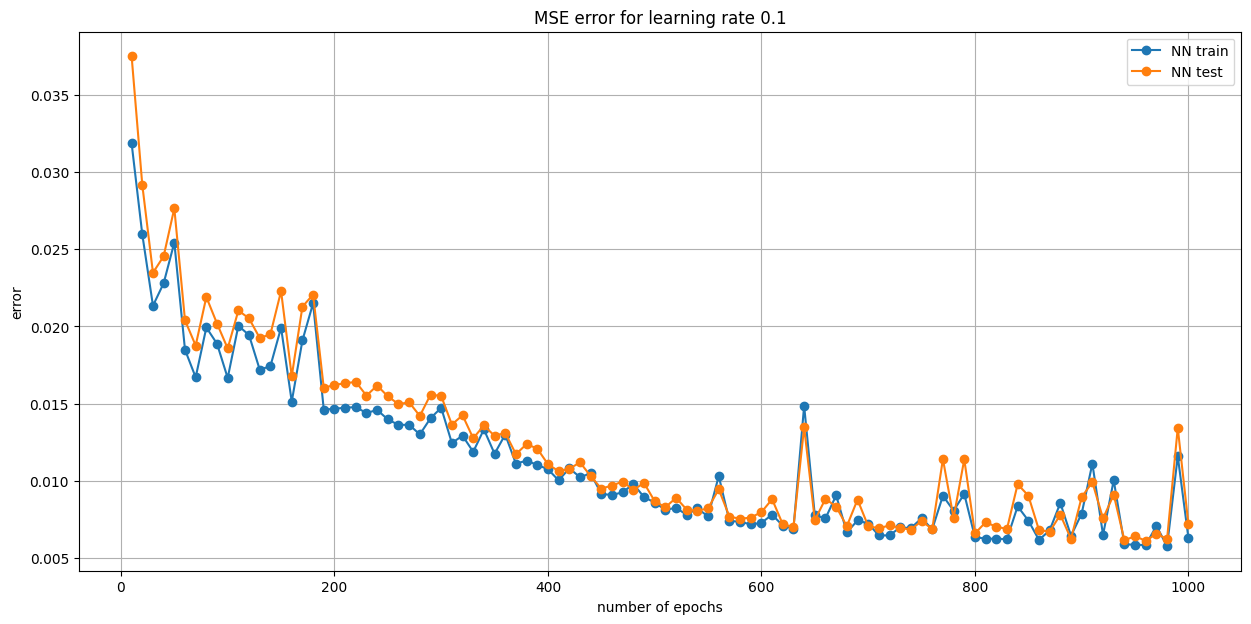

In [36]:
fig = plt.figure(figsize=(15, 7))
axs = plt.gca()

axs.plot(mse_r2[:,0]+1,mse_r2[:,1], marker='o', linestyle='-', label=r'NN train')

axs.plot(mse_r2[:,0]+1,mse_r2[:,3], marker='o', linestyle='-', label=r'NN test')

axs.legend()
plt.grid()
axs.set(xlabel =r'number of epochs', ylabel= r'error', title = r'MSE error for learning rate {}'.format(gamma))

[Text(0.5, 0, 'number of epochs'),
 Text(0, 0.5, 'error'),
 Text(0.5, 1.0, ' $R^2$ error for learning rate 0.1')]

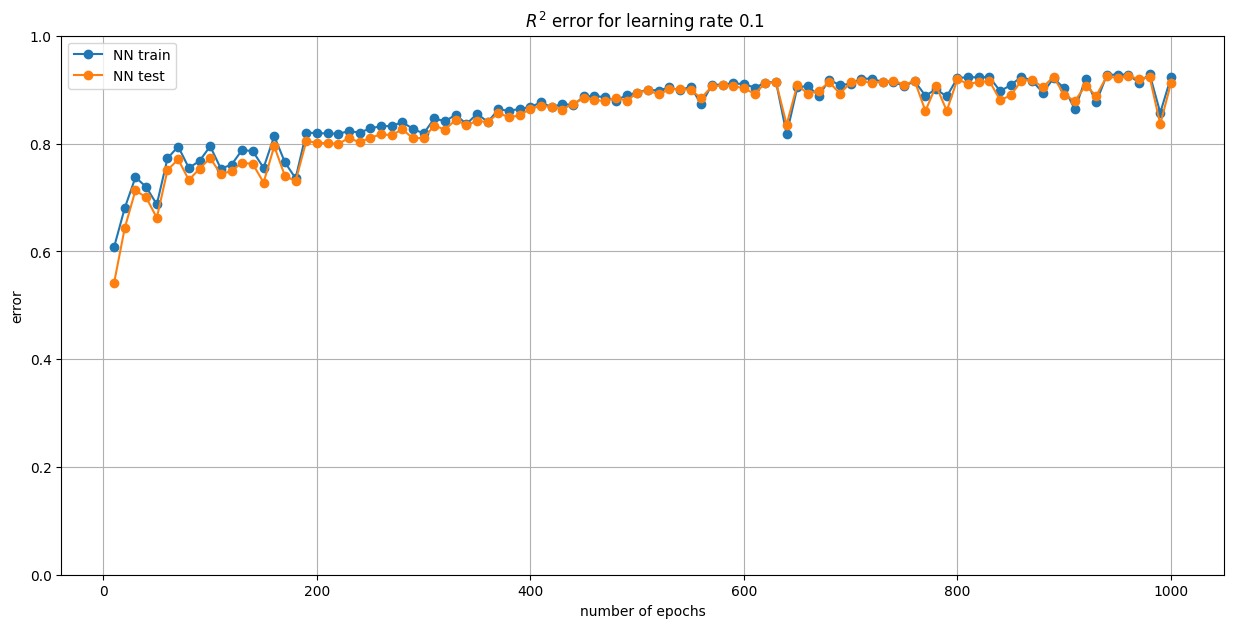

In [37]:
fig = plt.figure(figsize=(15, 7))
axs = plt.gca()

axs.plot(mse_r2[:,0]+1,mse_r2[:,2], marker='o', linestyle='-', label=r'NN train')
axs.plot(mse_r2[:,0]+1,mse_r2[:,4], marker='o', linestyle='-', label=r'NN test')
axs.set_ylim(0,1)
axs.legend()
plt.grid()
axs.set(xlabel =r'number of epochs', ylabel= r'error', title = r' $R^2$ error for learning rate {}'.format(gamma))

### try different network sizes
- restrict to two hidden layers but change the number of perceptrons for each layer

In [13]:
#X = design_with_in(x1_scaled.flatten(),x2_scaled.flatten(), deg + 1)
X = np.hstack((x1_scaled, x2_scaled))
y = y_scaled.flatten().reshape((-1,1))


# chooose seed
np.random.seed(0)

# HISHEM: 2, 50 , 25, 1


network_input_size = 2 # bcs have 2 features
layer_output_sizes = [50, 25, 1]
size_s = [network_input_size, layer_output_sizes]


activation_funcs = [sigmoid for i in range(len(layer_output_sizes)-1)]
activation_funcs.append(Id)
activation_ders = [sigmoid_der for i in range(len(layer_output_sizes)-1)]
activation_ders.append(lambda x: 1)

print(activation_funcs)

gamma=0.1
M = 4
n_epochs = 500

[<function sigmoid at 0x7f2d428bc360>, <function sigmoid at 0x7f2d428bc360>, <function Id at 0x7f2d428bc9a0>]


In [62]:
from tqdm import tqdm
from joblib import Parallel, delayed

In [ ]:
from sklearn.model_selection import KFold
k = 5
kfold = KFold(n_splits = k)

hidden_sizess0 = [10, 25, 50, 75, 100, 125]
hidden_sizess1 = [10, 25, 50, 75, 100, 125]

Errors_CV = np.zeros((len(hidden_sizess0), len(hidden_sizess1), 2))

def cross_validation_score(i, j, X, y):
    error_r2 = []
    error_mse = []
    for train_inds, test_inds in kfold.split(X):
        scalerX = MinMaxScaler()
        X_train = scalerX.fit_transform(X[train_inds])
        X_test = scalerX.fit_transform(X[test_inds])

        y_train = y[train_inds]
        y_test = y[test_inds]

        size_s = [2, [hidden_sizess0[i], hidden_sizess1[j], 1]]

        M = 4
        gamma = 0.1
        
        layers_final = sgd_momentum(X_train, y_train, size_s, sum_c_i, 'FFNN', activation_funcs, activation_ders, n_epochs=n_epochs, M=M, gamma=gamma, momentum=0, verbose=False, method2='regression')
        pred = feed_forward_batch(X_test, layers_final, activation_funcs)

        error_r2.append(r2_score(y_test, pred))
        error_mse.append(mean_squared_error(y_test, pred))

    #print(error_r2)
    mean_mse = np.mean(error_mse)
    mean_r2 = np.mean(error_r2)
    return i, j, mean_mse, mean_r2

# Use joblib.Parallel to parallelize the inner loops
results = Parallel(n_jobs=-1)(delayed(cross_validation_score)(i, j, X_train, y_train) for i in tqdm(range(len(hidden_sizess0)), desc='Outer Loop') for j in tqdm(range(len(hidden_sizess1)), desc='Inner Loop', leave=False))

# Collect the results
for i, j, mean_mse, mean_r2 in results:
    Errors_CV[i, j, 0] = mean_mse
    Errors_CV[i, j, 1] = mean_r2

#np.save('crossvalidation_of_layersizes10,25,50,75,100,125_gam0.1_M4_nepochs500_0-mse_1-r2_.npy', Errors_CV)

In [64]:
#Errors_CV = np.load('crossvalidation_of_layersizes10,25,50,75,100,125_gam0.1_M4_nepochs500_0-mse_1-r2_.npy')

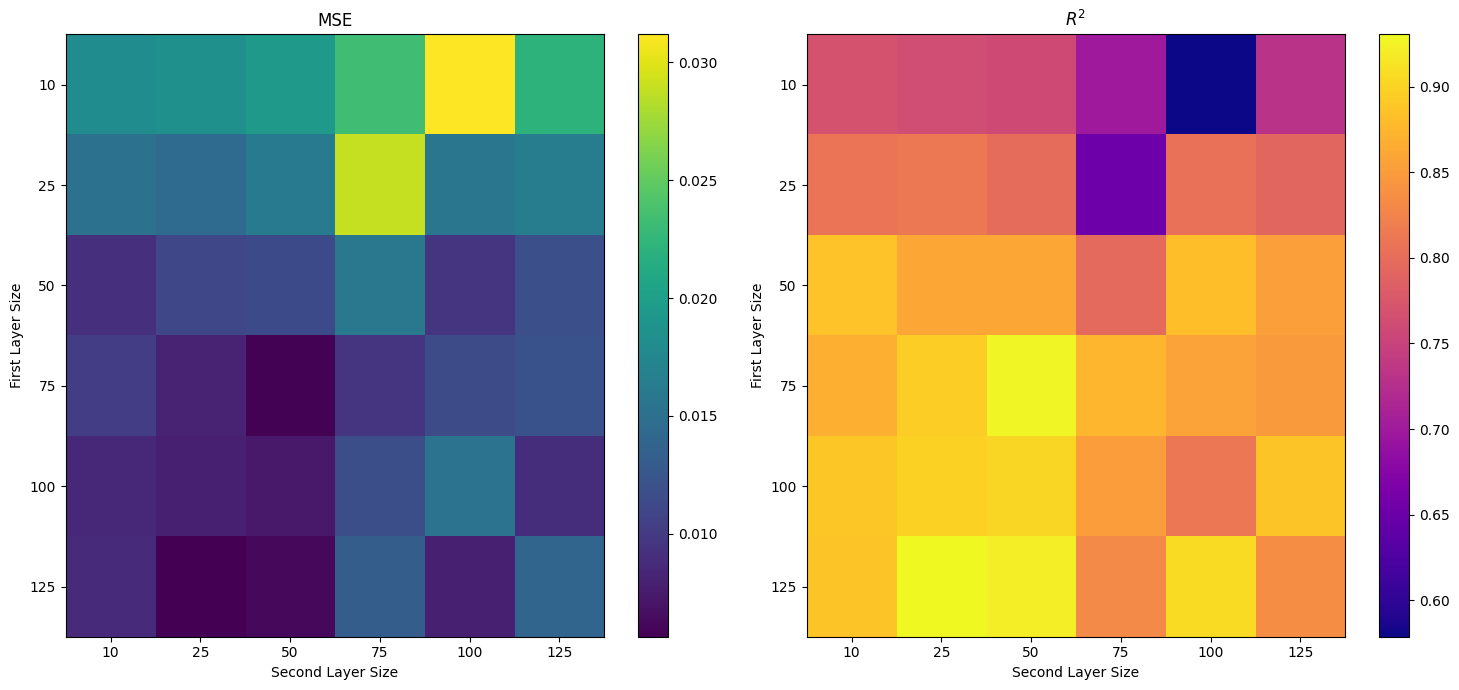

In [66]:
hidden_sizess0 = [10, 25, 50, 75, 100, 125]
hidden_sizess1 = [10, 25, 50, 75, 100, 125]
# Create a figure with two subplots
from copy import deepcopy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))  # 1 row, 2 columns

# Plot the first heatmap (MSE)
cax1 = ax1.imshow(Errors_CV[:, :, 0], cmap='viridis', aspect='auto')
ax1.set_title('MSE')

# Set x and y ticks and labels for the first heatmap
ax1.set_xticks(np.arange(len(hidden_sizess1)))
ax1.set_xticklabels(hidden_sizess1)
ax1.set_yticks(np.arange(len(hidden_sizess0)))
ax1.set_yticklabels(hidden_sizess0)
ax1.set_xlabel('Second Layer Size')
ax1.set_ylabel('First Layer Size')
fig.colorbar(cax1, ax=ax1)  # Add colorbar to the heatmap

# Plot the second heatmap (R^2)
atri = deepcopy(Errors_CV[:, :, 1])
atri[atri < 0] = -0.5
cax2 = ax2.imshow(atri, cmap='plasma', aspect='auto')
ax2.set_title(r'$R^2$')

# Set x and y ticks and labels for the second heatmap
ax2.set_xticks(np.arange(len(hidden_sizess1)))
ax2.set_xticklabels(hidden_sizess1)
ax2.set_yticks(np.arange(len(hidden_sizess0)))
ax2.set_yticklabels(hidden_sizess0)
ax2.set_xlabel('Second Layer Size')
ax2.set_ylabel('First Layer Size')
fig.colorbar(cax2, ax=ax2)  # Add colorbar to the heatmap

# Adjust the layout to make room for titles and colorbars
plt.tight_layout()

#plt.savefig('crossvalidation_of_layersizes10,25,50,75,100,125_gam0.1_M4_nepochs500_0-mse_1-r2_.png')

plt.show()
#print(Errors_CV[:, :, 1])



trying  crossvalidation multiple times → get the best results for the first layer size 75 and the second layersize 50.

In [71]:
# chooose seed
np.random.seed(0)

network_input_size = 2 # bcs have 2 features
layer_output_sizes = [75, 50, 1]
size_s = [network_input_size, layer_output_sizes]


activation_funcs = [sigmoid for i in range(len(layer_output_sizes)-1)]
activation_funcs.append(Id)
activation_ders = [sigmoid_der for i in range(len(layer_output_sizes)-1)]
activation_ders.append(lambda x: 1)


gamma=0.1
M = 4
n_epochs = 2000
# = sgd_momentum(X_train,y_train, size_s, sum_c_i, 'FFNN', activation_funcs, activation_ders, lamb=0, n_epochs=200, M=M, gamma=gamma, momentum = 0, verbose=True)
layers_ffnn, mse_r2 = sgd_momentum(X_train,y_train, size_s, sum_c_i, 'FFNN', activation_funcs, activation_ders, cost_der=mse_der, lamb=0, n_epochs=n_epochs, M=M, gamma=gamma, momentum = 0.0, verbose=True, method2='regression',X_test=X_test, y_test=y_test)

[Text(0.5, 0, 'number of epochs'),
 Text(0, 0.5, 'error'),
 Text(0.5, 1.0, 'MSE error for stochastic graadient descent with batch size 4, learning rate 0.1 and hidden layer sizes 75 and 50 ')]

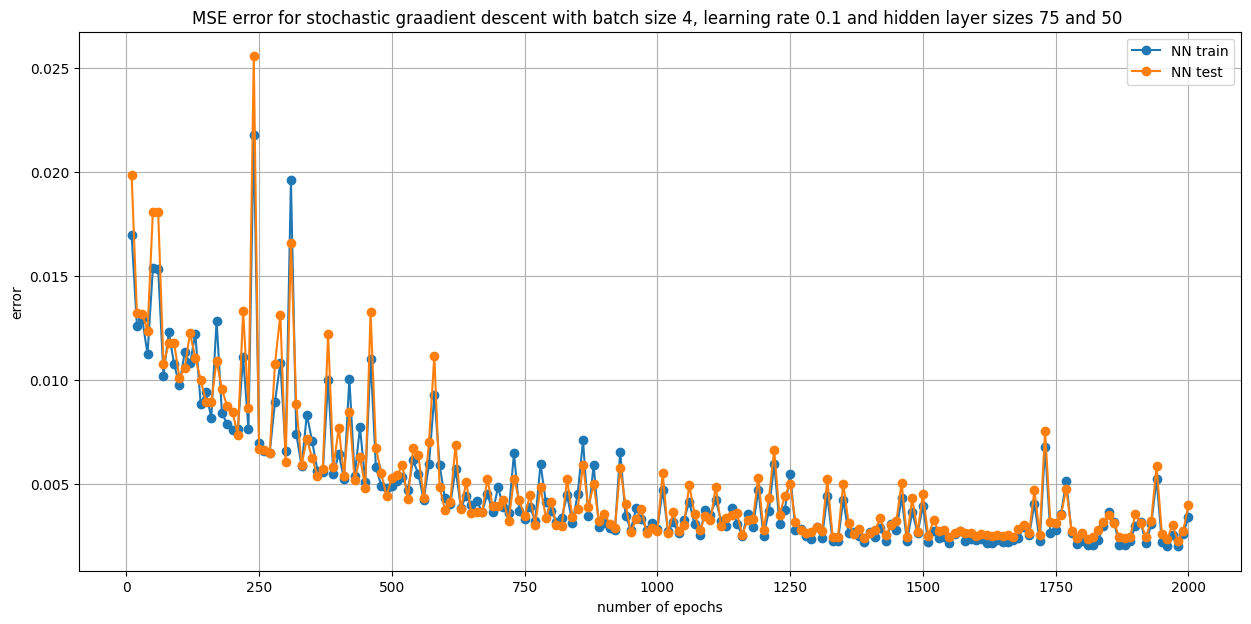

In [72]:
fig = plt.figure(figsize=(15, 7))
axs = plt.gca()

axs.plot(mse_r2[:,0]+1,mse_r2[:,1], marker='o', linestyle='-', label=r'NN train')

axs.plot(mse_r2[:,0]+1,mse_r2[:,3], marker='o', linestyle='-', label=r'NN test')

axs.legend()
plt.grid()
axs.set(xlabel =r'number of epochs', ylabel= r'error', title = r'MSE error for stochastic graadient descent with batch size 4, learning rate 0.1 and hidden layer sizes 75 and 50 ')

[Text(0.5, 0, 'number of epochs'),
 Text(0, 0.5, 'error'),
 Text(0.5, 1.0, '$R^2$ error for stochastic graadient descent with batch size 4, learning rate 0.1 and hidden layer sizes 75 and 50 ')]

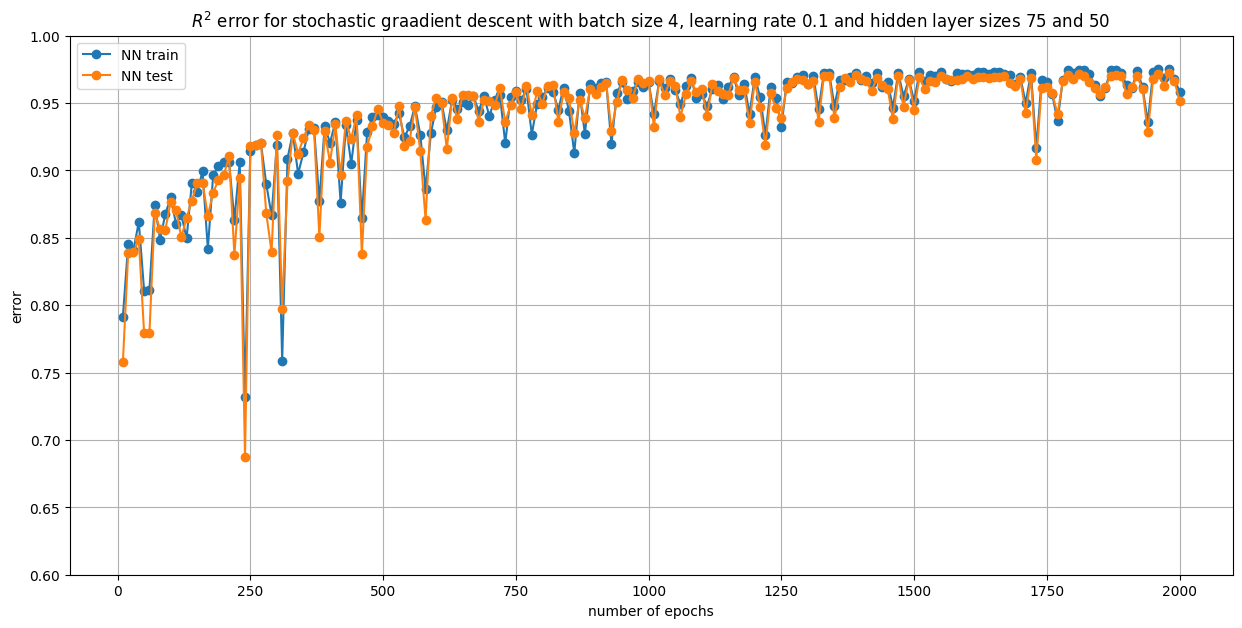

In [73]:
fig = plt.figure(figsize=(15, 7))
axs = plt.gca()

axs.plot(mse_r2[:,0]+1,mse_r2[:,2], marker='o', linestyle='-', label=r'NN train')
axs.plot(mse_r2[:,0]+1,mse_r2[:,4], marker='o', linestyle='-', label=r'NN test')
axs.set_ylim(0.6,1)
axs.legend()
plt.grid()
axs.set(xlabel =r'number of epochs', ylabel= r'error', title = r'$R^2$ error for stochastic graadient descent with batch size 4, learning rate 0.1 and hidden layer sizes 75 and 50 ')

- we get really great results, if we increase the number of epochs it will probably even get better due to the shape of the error, however it still sometimes decreases drastically which is not nice

## comparison of selected choice with OLS & RIDGE

In [74]:
# OLS
# saw in part a) that the following works:
n_epochs = 2000
M = 10 # size of the minibatches
gamma = 0.01


deg = 15
X_deg = design_with_in(x1_train.reshape(-1),x2_train.reshape(-1), deg + 1)
X_deg_test = design_with_in(x1_test.reshape(-1),x2_test.reshape(-1), deg + 1)
# standardization
scaler_xdeg = StandardScaler()
scaler_ydeg = StandardScaler()
X_deg = scaler_xdeg.fit_transform(X_deg)
X_deg_test = scaler_xdeg.fit_transform(X_deg_test)
y_deg = scaler_ydeg.fit_transform(y_train.reshape(-1,1)).reshape(-1,1)

size_s = X_deg.shape[1]
#beta_5dg, mse_r2_5deg = sgd_momentum(X_deg,y_deg, size_s, sum_c_i, 'OLS', activation_funcs, activation_ders, lamb=0, n_epochs=n_epochs, M=M, gamma=gamma, momentum = 0, verbose=True, scaler_y=scaler_ydeg)
_, mse_r2_5deg = sgd_momentum(X_deg,y_deg, size_s, sum_c_i, 'OLS', n_epochs=n_epochs, M=M, gamma=gamma, momentum = 0.0, verbose=True, method2='regression',X_test=X_deg_test, y_test=y_test, scaler_y=scaler_ydeg)

In [75]:
# RIDGE
# saw in part a) that the following works: 

n_epochs = 2000
M = 5 # size of the minibatches
gamma = 0.01

In [76]:
deg = 15
lamb = 0.001
X_deg = design_no_in(x1_train.reshape(-1),x2_train.reshape(-1), deg + 1)
X_deg_test = design_no_in(x1_test.reshape(-1),x2_test.reshape(-1), deg + 1)

# standardization
scaler_xdeg = StandardScaler()
scaler_ydeg = StandardScaler()
X_deg = scaler_xdeg.fit_transform(X_deg)
X_deg_test = scaler_xdeg.fit_transform(X_deg_test)
y_deg = scaler_ydeg.fit_transform(y_train.reshape(-1,1)).reshape(-1,1)


size_s = X_deg.shape[1]
#_, mse_r2_rid = sgd_momentum(X_deg,y_deg, size_s, sum_c_i, 'OLS', activation_funcs, activation_ders, lamb=lamb, n_epochs=n_epochs, M=M, gamma=gamma, momentum = 0, verbose=True, scaler_y=scaler_ydeg)
_, mse_r2_rid = sgd_momentum(X_deg,y_deg, size_s, sum_c_i, 'OLS', lamb=lamb, n_epochs=n_epochs, M=M, gamma=gamma, momentum = 0.0, verbose=True, method2='regression',X_test=X_deg_test, y_test=y_test, scaler_y=scaler_ydeg)

In [ ]:
fig = plt.figure(figsize=(15, 7))
axs = plt.gca()

axs.plot(mse_r2[:,0]+1,mse_r2[:,1], marker='o', linestyle='-', label=r'NN train')
axs.plot(mse_r2_5deg[:,0]+1,mse_r2_5deg[:,1], marker='o', linestyle='-', label=r'OLS train')
axs.plot(mse_r2_rid[:,0]+1,mse_r2_rid[:,1], marker='o', linestyle='-', label=r'RIDGE train')
axs.plot(mse_r2[:,0]+1,mse_r2[:,3], marker='o', linestyle='-', label=r'NN test')
axs.plot(mse_r2_5deg[:,0]+1,mse_r2_5deg[:,3], marker='o', linestyle='-', label=r'OLS test')
axs.plot(mse_r2_rid[:,0]+1,mse_r2_rid[:,3], marker='o', linestyle='-', label=r'RIDGE test')
axs.set_ylim(0,0.1)

axs.legend()
plt.grid()
axs.set(xlabel =r'number of epochs', ylabel= r'error', title = r'MSE error for {} epochs'.format(n_epochs))

plt.savefig('MSE_comparison_OLS_RIDGE_NN_2b.png')

[Text(0.5, 0, 'number of epochs'),
 Text(0, 0.5, 'error'),
 Text(0.5, 1.0, ' $R^2$ error for 2000 epochs')]

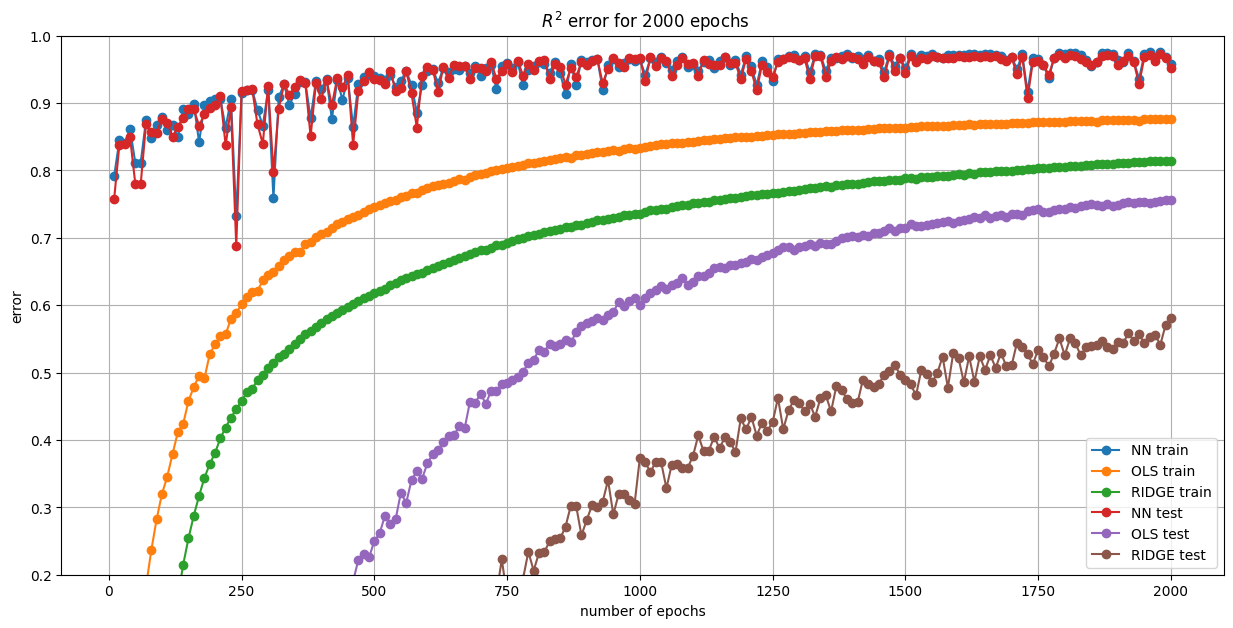

In [78]:
fig = plt.figure(figsize=(15, 7))
axs = plt.gca()

axs.plot(mse_r2[:,0]+1,mse_r2[:,2], marker='o', linestyle='-', label=r'NN train')
axs.plot(mse_r2_5deg[:,0]+1,mse_r2_5deg[:,2], marker='o', linestyle='-', label=r'OLS train')
axs.plot(mse_r2_rid[:,0]+1,mse_r2_rid[:,2], marker='o', linestyle='-', label=r'RIDGE train')
axs.plot(mse_r2[:,0]+1,mse_r2[:,4], marker='o', linestyle='-', label=r'NN test')
axs.plot(mse_r2_5deg[:,0]+1,mse_r2_5deg[:,4], marker='o', linestyle='-', label=r'OLS test')
axs.plot(mse_r2_rid[:,0]+1,mse_r2_rid[:,4], marker='o', linestyle='-', label=r'RIDGE test')
axs.set_ylim(0.2,1)
axs.legend()
plt.grid()
axs.set(xlabel =r'number of epochs', ylabel= r'error', title = r' $R^2$ error for {} epochs'.format(n_epochs))

#plt.savefig('R2_comparison_OLS_RIDGE_NN_2b.png')